# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [1]:
import os

import matplotlib

# Colab uses Matplotlib version 3.2.2 by default.
# Version 3.3.0 or above is better for proper plt.stem work.
# Comment/remove this block if you're OK with plt.stem warnings.
# Run the notebook again after running this cell.
if matplotlib.__version__ < "3.3.0":
    !pip install -Uq --force-reinstall matplotlib
    os.kill(os.getpid(), 9)

In [2]:
import hashlib
import IPython.display as ipd

import librosa
import librosa.display
import librosa.filters
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy 
import scipy.fft

# Disable division by zero in numpy:
np.seterr(divide='raise', invalid='raise');

In [3]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    plt.grid(True)
    librosa.display.waveplot(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.grid(True)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()

In [4]:
# Создадим несколько простых сигналов,
# они понадобятся нам для дальнейшего тестирования.
signals = {}

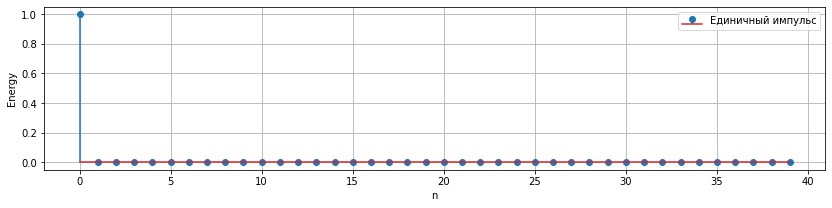

In [5]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0] * 39, dtype=float)
draw_sig(signals[name], name)

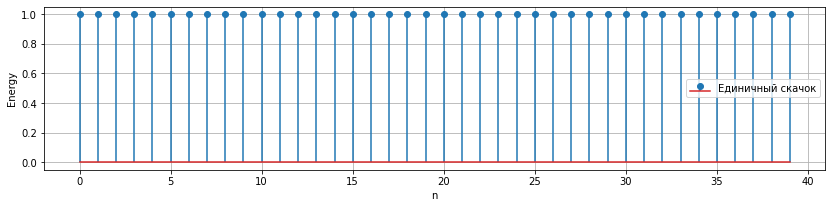

In [6]:
name = "Единичный скачок"
signals[name] = np.array([1] * 40, dtype=float) 
draw_sig(signals[name], name)

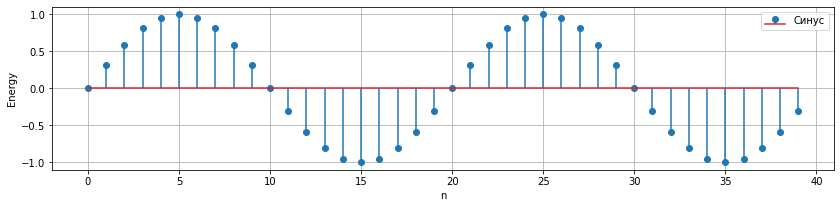

In [7]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40) / 10)
draw_sig(signals[name], name)

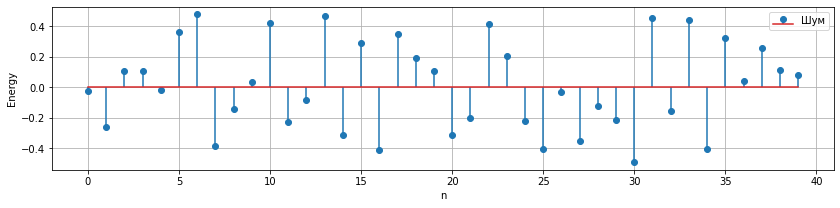

In [8]:
name = "Шум"
signals[name] = np.random.random(40) - 0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT):
$$\displaystyle X_k = \sum_{n=0}^{N-1} x_n e^{\frac{-2\pi i}{N} k n}$$

# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией `scipy.fft.fft`.

In [9]:
def DFT(x):
    N = len(x)
    n = np.arange(N).reshape(1, -1)
    k = np.arange(N).reshape(-1, 1)
    w_matrix = np.exp(-2j * np.pi * k * n / N)
    return np.dot(x, w_matrix)
    # For-loop version:
    # X = np.zeros_like(x, dtype=np.complex64)
    # for k in range(N):
        # w_vector = np.exp(-2j * np.pi * k * np.arange(N) / N)
        # X[k] = np.sum(x * w_vector)
    # return X

In [10]:
def test_DTF(x, transform=DFT):
    # Сравнение с библиотекой scipy
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}.")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}.")
        print(f"Your DTF spectrogram: {curr_result}.")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}.")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation."
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток — сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N logN)$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с `scipy.fft.fft`.

In [11]:
def FFT(x):
    N = len(x)

    if N % 2 != 0:  # perform DFT if N is odd
        n = np.arange(N).reshape(1, -1)
        k = np.arange(N).reshape(-1, 1)
        w_matrix = np.exp(-2j * np.pi * k * n / N)
        return np.dot(x, w_matrix)
    else:  # perform FFT otherwise
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        w_vector = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + w_vector[:N // 2] * X_odd,
                               X_even + w_vector[N // 2:] * X_odd])

In [12]:
for name, sig in signals.items():
    print(f"Checking '{name}':")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation."
print("All OK!")

Checking 'Единичный импульс':
TEST PASSED
Checking 'Единичный скачок':
TEST PASSED
Checking 'Синус':
TEST PASSED
Checking 'Шум':
TEST PASSED
All OK!


# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый — как меняется угол, образуемый на комплексной плоскости.

# Задание 2 (1 балл)
Реализовать функции построения амплитудного и фазового спектра.

In [13]:
# Функция построения амплитудного спектра
def get_magnitude_from_spec(spec):
    return np.absolute(spec)

# Функция построения фазового спектра
def get_phi_from_spec(spec):
    return np.angle(spec)

In [14]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}.")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad variance. Expected {var}, got {np.var(sig)}.")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_magnitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong magnitude."
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong phase."

_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_magnitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  magnitude."
assert get_magnitude_from_spec(_spec)[0] == 10, \
    "Wrong magnitude."
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase."

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10 + 5j] 
                                              + [0] * 6 + [10 - 5j])))
assert get_magnitude_from_spec(_spec).round(1)[1] == 11.2, \
    "Wrong magnitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5, \
    "Wrong phase. Make sure it is an angle."

print("All OK!")

All OK!


In [15]:
# Определим ещё одну функцию для отрисовки.
# Теперь будем рисовать сигнал в частотной области.
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec) < 100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # поэтому будем рисовать огибающую функцию:
        draw_func = plt.plot

    if draw_A:
        plt.figure(figsize=figsize)
        plt.grid(True)
        plt.title("Magnitude spectrum")
        magn = get_magnitude_from_spec(spec)
        draw_func(magn)
        plt.xlabel("n")
        plt.ylabel("Magnitude")
        if name is not None:
            plt.legend([name])
        plt.show()

    if draw_p:
        plt.figure(figsize=figsize)
        plt.grid(True)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.xlabel("n")
        plt.ylabel("Radian")
        if name is not None:
                plt.legend([name])
        plt.show()

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции `signals` и ответьте на вопросы:
1. Почему амплитуда всех гармоник единичного импульса равна единице?
2. Какие выводы можно сделать, смотря на амплитудный спектр? А на фазовый?
3. Как перевести номер отсчёта в частоту?
4. Что в фазовом спектре является полезной информацией, а что — шумом? Почему?

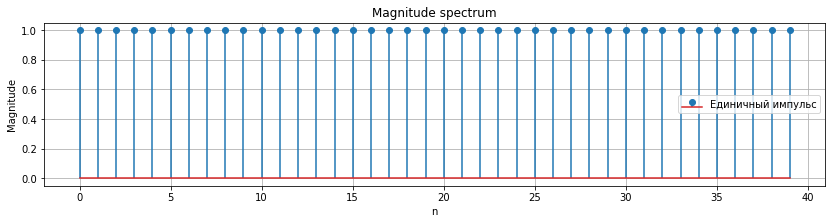

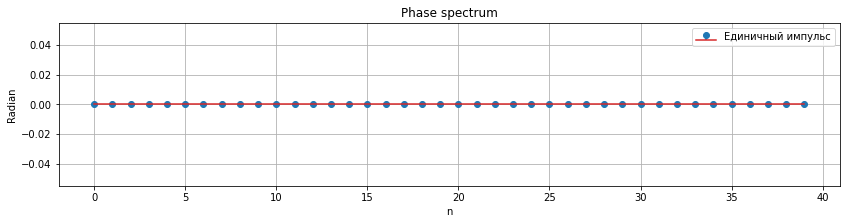

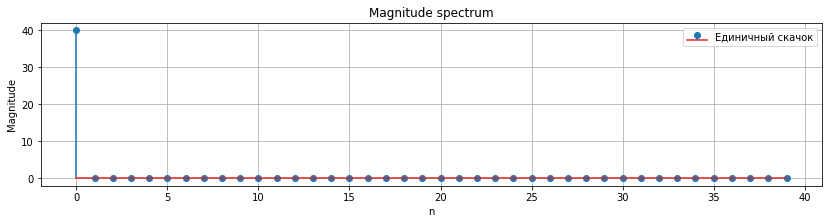

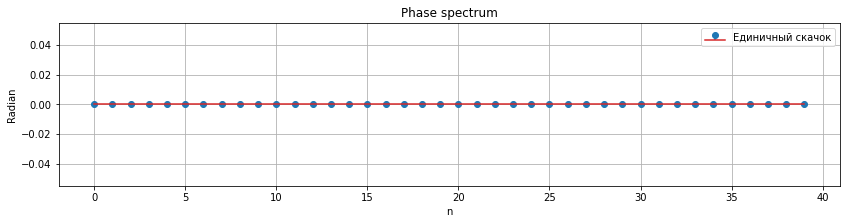

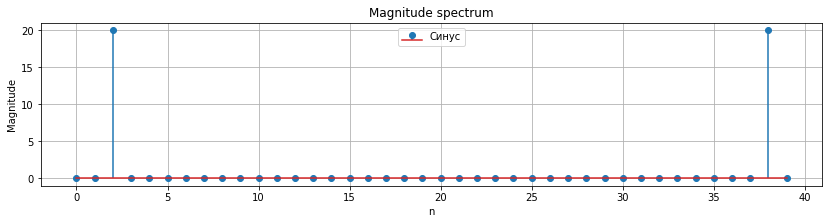

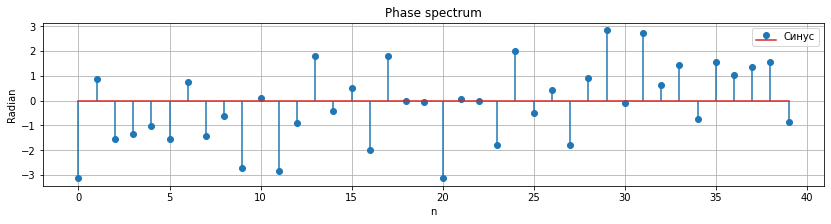

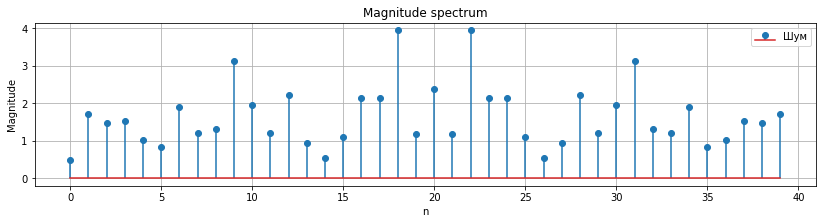

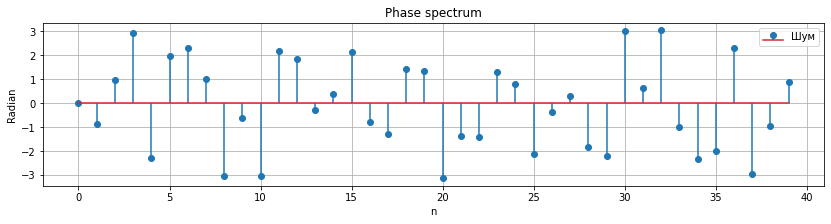

In [16]:
for name, signal in signals.items():
    draw_spec(scipy.fft.fft(signal), name=name)

1. Поскольку единичный импульс равен нулю во всех точках, кроме начальной, то согласно формуле анализа все точки спектра такого сигнала будут представлять собой произведение единицы (значение сигнала в начальной точке) на экспоненту в нулевой степени (тоже единицу).
2. По амплитудному спектру можно сделать вывод о вкладе определённых частот в спектр исходного сигнала (чем выше амплитуда гармоники, тем больше её вклад), по фазовому — о внутренней структуре сигнала, то есть о том, как одна гармоническая составляющая сдвинута относительно другой.
3. $\displaystyle f_k = \frac{k}{N}f_s$, где $k$ — номер интересующего отсчёта (гармоники), $N$ — общее число отсчётов.
4. Полезной информацией в фазовом спектре являются фазы информативных (основных) гармоник сигнала, шумом — фазы остальных гармоник. Хорошим примером является амплитудный и фазовый спектр синусоидального сигнала выше: несмотря на то, что амплитудный спектр явно говорит о наличии всего одной гармоники в сигнале, это было бы невозможно понять из фазового спектра, поскольку значения фаз отсутствующих в сигнале гармоник также ненулевые.

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.

# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье, пользуясь только библиотеками `numpy` и `scipy`. Сравнить с `librosa.stft`.

In [17]:
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    # Short-time Fourier transform
    # x - signal
    # n_fft - fft window size
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram
    x_padded = np.pad(x, int(n_fft // 2), mode='reflect')

    spectrogram = np.zeros((n_fft // 2 + 1, len(x) // hop_length + 1),
                           dtype=np.complex64)
    window = scipy.signal.get_window(window=window, Nx=n_fft, fftbins=True)

    for i in range(spectrogram.shape[1]):
        j = i * hop_length
        spectrogram[:, i] = scipy.fft.fft(x_padded[j:j + n_fft]
                                          * window)[:1 + n_fft // 2]

    return spectrogram

In [18]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length,
                                  window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != " \
              f"librosa stft shape {librosa_result.shape}.")
        return -1
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result - result)}.")
        return -2
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}':")
    for n_fft in (8, 4):
        for hop_length in (n_fft // 4, n_fft // 2):
            assert 0 == test_stft(sig, n_fft=n_fft, hop_length=hop_length), (
                f"Test failed. Params: n_fft={n_fft}, hop_length={hop_length}."
            )
    print("OK")
print("All OK!")

Checking 'Единичный импульс':
OK
Checking 'Единичный скачок':
OK
Checking 'Синус':
OK
Checking 'Шум':
OK
All OK!


In [19]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    plt.grid(True)
    # X - комплексная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов. Для этого нам понадобятся все определённые выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнём с простого сигнала, состоящего из нескольких основных гармоник и шума.

Number of samples: 82175. Sample rate: 22050


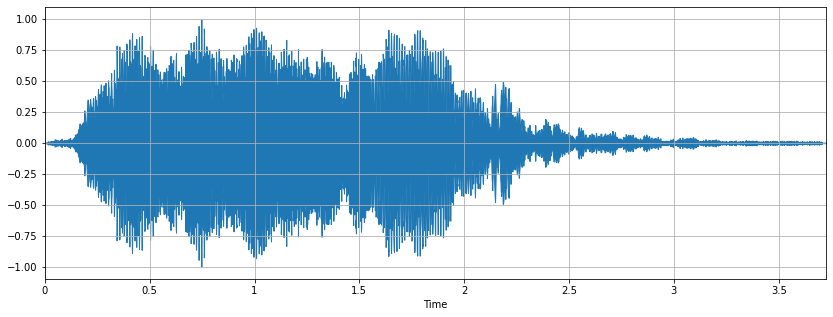

In [20]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources/train_whistle.wav")
print(f"Number of samples: {len(train_whistle)}. Sample rate: {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Гудок паровоза в частотной области


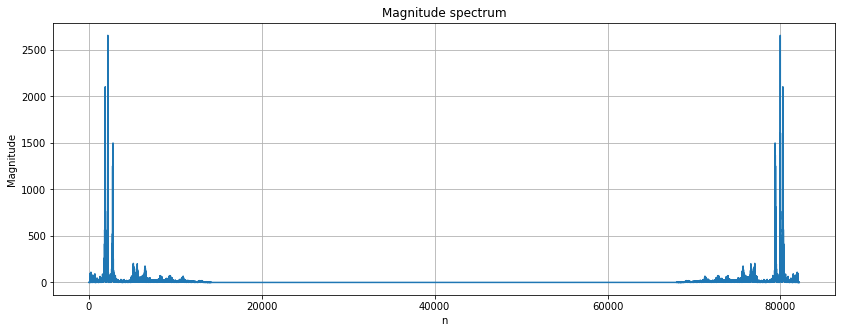

In [21]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(14, 5))

# Задание 4 (2 балла)

Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


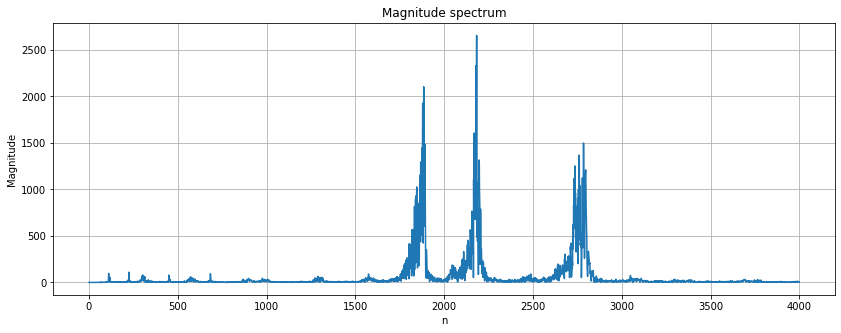

In [22]:
draw_spec(train_whistle_spec[:4000], draw_p=False, figsize=(14, 5))

In [23]:
freq_1 = np.argmax(np.absolute(train_whistle_spec[1500:2000])) + 1500
freq_2 = np.argmax(np.absolute(train_whistle_spec[2000:2500])) + 2000
freq_3 = np.argmax(np.absolute(train_whistle_spec[2500:3000])) + 2500

freqs = np.array([freq_1, freq_2, freq_3])
task_answer = np.round(tw_sr * freqs / len(train_whistle_spec), 2)
print(f"Harmonics: {', '.join(freqs.astype(str))}.")
print(f"Frequencies (Hz): {', '.join(task_answer.astype(str))}.")

Harmonics: 1885, 2183, 2785.
Frequencies (Hz): 505.8, 585.76, 747.3.


In [24]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. " \
        f"Got {type(task_answer)}."
assert len(task_answer) == 3, f"Wrong length: {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and \
        round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer) - 1836) <= 3 and \
         abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong frequencies."
print("Correct!")

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

In [25]:
def signal_gen(frequency=506, sample_rate=tw_sr):
    np.random.seed(seed=44)
    gen_len = len(train_whistle)
    t = np.arange(gen_len)
    signal = np.cos(2 * np.pi * frequency / sample_rate * t)
    return signal

In [26]:
signal = signal_gen(freq_1) + signal_gen(freq_2) + signal_gen(freq_3)

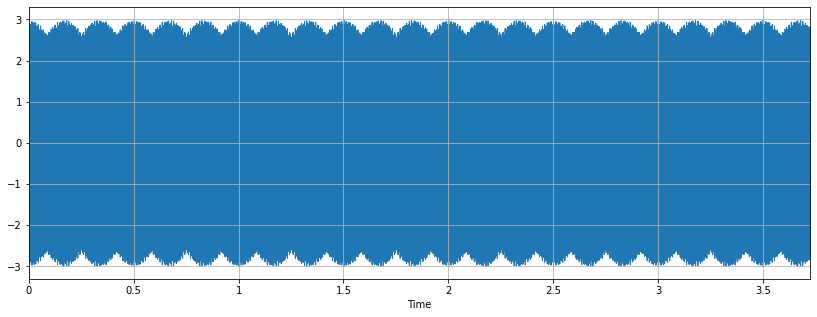

In [27]:
draw_waveform(signal, sr=tw_sr)

In [28]:
# Осторожно, звук не такой приятный, как у паровоза!
ipd.Audio(signal, rate=tw_sr)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал — [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трёхзначный номер. Используя таблицу с [Wiki](https://ru.wikipedia.org/wiki/DTMF), определите, что за номер закодирован.

Number of samples: 243102. Sample rate: 22050.


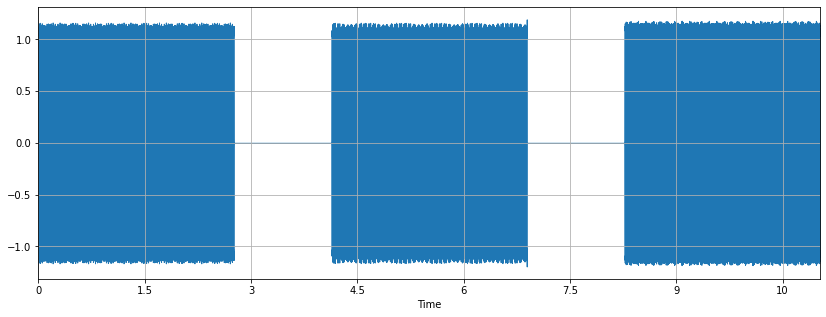

In [29]:
dtmf, dtmf_sr = librosa.core.load("resources/dtmf.wav")
print(f"Number of samples: {len(dtmf)}. Sample rate: {dtmf_sr}.")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

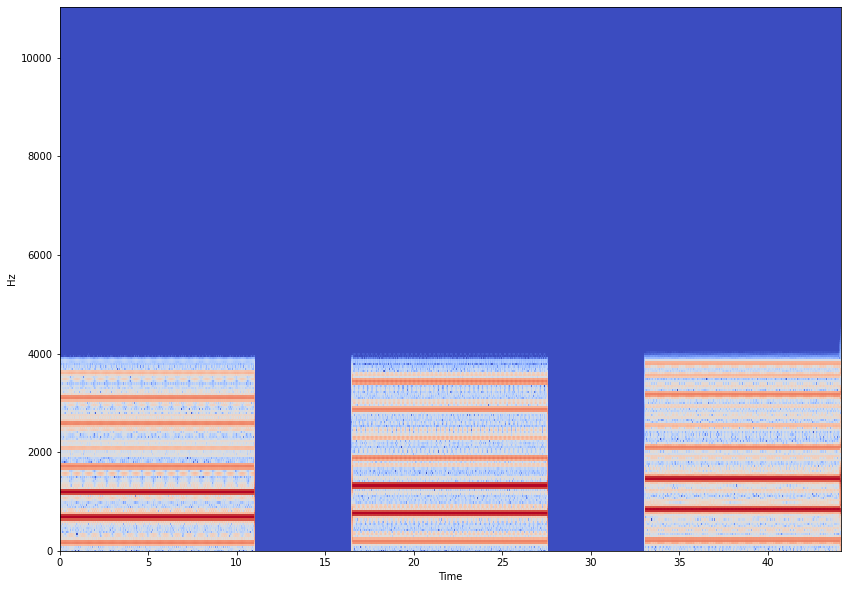

In [30]:
spectrogram = librosa.stft(dtmf, n_fft=512, window='hann', center=True)
draw_stft(spectrogram, sr=dtmf_sr, figsize=(14, 10))

In [31]:
phone_number = [1, 5, 9]

In [32]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. " \
        f"Got {type(phone_number)}."
assert len(phone_number) == 3, f"Wrong length: {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11, \
        f"Wrong number."
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == \
       "140f6969d5213fd0ece03148e62e461e", \
       f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   

Correct!
